In [ ]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# Construct a tf.data.Dataset
data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin', names = ['polarity','id','date','query','user','text'])

In [ ]:
data = data.sample(frac=1)
data = data[:200000]

In [ ]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 6)


In [ ]:
#Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text
data.head(10)

,polarity,id,date,query,user,text
475555,0,2177636753,Mon Jun 15 06:27:00 PDT 2009,NO_QUERY,dhifa,our very last day http://post.ly/qrw
71915,0,1694089162,Mon May 04 01:02:08 PDT 2009,NO_QUERY,simpwn,24 hours of no sleep again... cant wait for t...
17370,0,1556261953,Sat Apr 18 22:11:22 PDT 2009,NO_QUERY,aleskywalker,@nick_carter Where's my shout out?? I told you...
550702,0,2202977866,Tue Jun 16 22:46:53 PDT 2009,NO_QUERY,PhannieTV,please!! hope and time.. nothing more! D:
849827,4,1565229961,Mon Apr 20 06:14:33 PDT 2009,NO_QUERY,jennlyn54,running late...as usual! ;) LOL ...oh well! Ha...
120343,0,1833079971,Sun May 17 22:14:15 PDT 2009,NO_QUERY,trishaglitzy,"@buhgonz beybey its okay, we're here for you!"
757531,0,2295365530,Tue Jun 23 07:50:03 PDT 2009,NO_QUERY,Johnniebucketz,in class..sober .....whos down to get frost ...
913629,4,1752671920,Sat May 09 22:36:23 PDT 2009,NO_QUERY,KimberlyAcuna,Having bro-lights with g.Soll CHEERS! http:/...
830197,4,1557271801,Sun Apr 19 03:03:43 PDT 2009,NO_QUERY,Archy_sailor,@stephenfry Seems like you're happy to be back...
1384344,4,2052649719,Sat Jun 06 01:29:28 PDT 2009,NO_QUERY,miriareu48,Lol @ airene. I'm intergrated to the max


In [ ]:
data['polarity'].unique()

array([0, 4])

In [ ]:

# Replacing the value 4 -->1 for ease of understanding.

data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
475555,0,2177636753,Mon Jun 15 06:27:00 PDT 2009,NO_QUERY,dhifa,our very last day http://post.ly/qrw
71915,0,1694089162,Mon May 04 01:02:08 PDT 2009,NO_QUERY,simpwn,24 hours of no sleep again... cant wait for t...
17370,0,1556261953,Sat Apr 18 22:11:22 PDT 2009,NO_QUERY,aleskywalker,@nick_carter Where's my shout out?? I told you...
550702,0,2202977866,Tue Jun 16 22:46:53 PDT 2009,NO_QUERY,PhannieTV,please!! hope and time.. nothing more! D:
849827,1,1565229961,Mon Apr 20 06:14:33 PDT 2009,NO_QUERY,jennlyn54,running late...as usual! ;) LOL ...oh well! Ha...


In [ ]:
data.describe()


,polarity,id
count,200000.000000,2.000000e+05
mean,0.501605,1.998303e+09
std,0.499999,1.939017e+08
min,0.000000,1.467811e+09
25%,0.000000,1.956735e+09
50%,1.000000,2.002043e+09
75%,1.000000,2.177036e+09
max,1.000000,2.329205e+09


In [ ]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         200000
No. of positve tagged sentences is:  100321
No. of negative tagged sentences is: 99679


In [ ]:
# get a word count per of text
def word_count(words):
    return len(words.split())

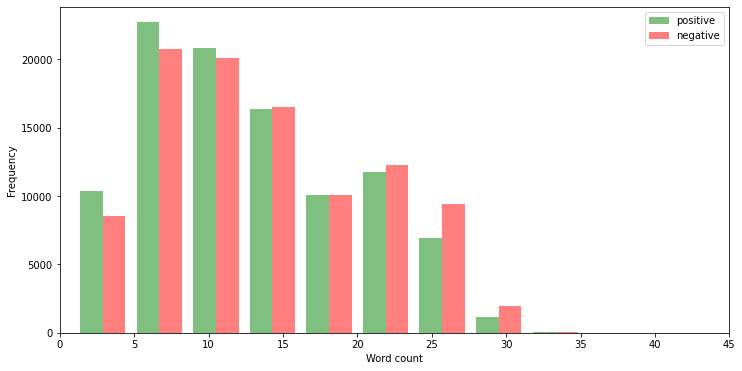

In [ ]:
#Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment
# plot word count distribution for both positive and negative 

data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity == 1]
n = data['word count'][data.polarity == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [ ]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(20)

[('the', 64589),
 ('and', 36991),
 ('you', 29717),
 ('for', 26531),
 ('have', 18048),
 ("i'm", 16027),
 ('that', 15917),
 ('but', 15735),
 ('just', 15693),
 ('with', 14265),
 ('not', 12698),
 ('was', 12670),
 ('this', 11152),
 ('get', 10071),
 ('good', 9885),
 ('like', 9508),
 ('are', 9468),
 ('all', 9448),
 ('out', 8643),
 ("it's", 8121)]

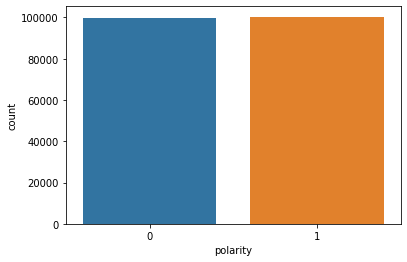

In [ ]:
#Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment

%matplotlib inline
sns.countplot(data['polarity'])

In [ ]:
# Removing the unnecessary columns.
data.drop(['date','query','user','word count'], axis=1, inplace=True)


In [ ]:
data.drop('id', axis=1, inplace=True)


In [ ]:
data.head(10)


,polarity,text
475555,0,our very last day http://post.ly/qrw
71915,0,24 hours of no sleep again... cant wait for t...
17370,0,@nick_carter Where's my shout out?? I told you...
550702,0,please!! hope and time.. nothing more! D:
849827,1,running late...as usual! ;) LOL ...oh well! Ha...
120343,0,"@buhgonz beybey its okay, we're here for you!"
757531,0,in class..sober .....whos down to get frost ...
913629,1,Having bro-lights with g.Soll CHEERS! http:/...
830197,1,@stephenfry Seems like you're happy to be back...
1384344,1,Lol @ airene. I'm intergrated to the max


In [ ]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [ ]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'to', 'both', 'whom', 'this', 'herself', 'm', 'during', "mightn't", 'had', 'after', 'isn', "shouldn't", 'been', "she's", 'mightn', 'an', 'into', 'about', 'here', 'these', 'up', 'haven', 'did', 'don', 'o', 'yourselves', 'than', "hasn't", "wouldn't", 'ours', 'or', 'so', 'its', 'should', 'only', 'again', "you'll", 'further', 'other', 'when', 'more', 'her', 'be', 'doing', 'being', "weren't", 'same', 'has', 'shouldn', "it's", 'on', 'ma', 't', 'all', 'am', 'nor', "didn't", 'needn', 'myself', 'any', 'each', 'they', 'own', 'you', 'our', 's', 'from', 'a', 'i', "you're", 'it', 'that', 'as', 'against', 'then', 'there', "should've", 'once', "mustn't", 'shan', 'will', "hadn't", 'just', 'doesn', 'very', 'y', 'weren', 'do', "needn't", 'theirs', "that'll", 'the', 'through', 'themselves', 'he', 're', 'their', 'me', 'yours', 'at', 'wasn', 'while', 'too', 'are', 'how', 'didn', 'won', 'does', 't

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

The Preprocessing steps taken are:

Lower Casing: Each text is converted to lowercase.
Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")

Removing Short Words: Words with length less than 2 are removed.
Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
data.head(10)

,polarity,text,processed_tweets
475555,0,our very last day http://post.ly/qrw,ur last day
71915,0,24 hours of no sleep again... cant wait for t...,hour sleep cant wait
17370,0,@nick_carter Where's my shout out?? I told you...,nickcarter wheres shout told pooh joke
550702,0,please!! hope and time.. nothing more! D:,please hope time nothing
849827,1,running late...as usual! ;) LOL ...oh well! Ha...,unning lateas usual lol oh well happy monday
120343,0,"@buhgonz beybey its okay, we're here for you!",buhgonz beybey okay
757531,0,in class..sober .....whos down to get frost ...,classsober who get frost hr got lol
913629,1,Having bro-lights with g.Soll CHEERS! http:/...,aving brolights gsoll cheer
830197,1,@stephenfry Seems like you're happy to be back...,stephenfry seems like youre happy back england...
1384344,1,Lol @ airene. I'm intergrated to the max,ol airene im intergrated max


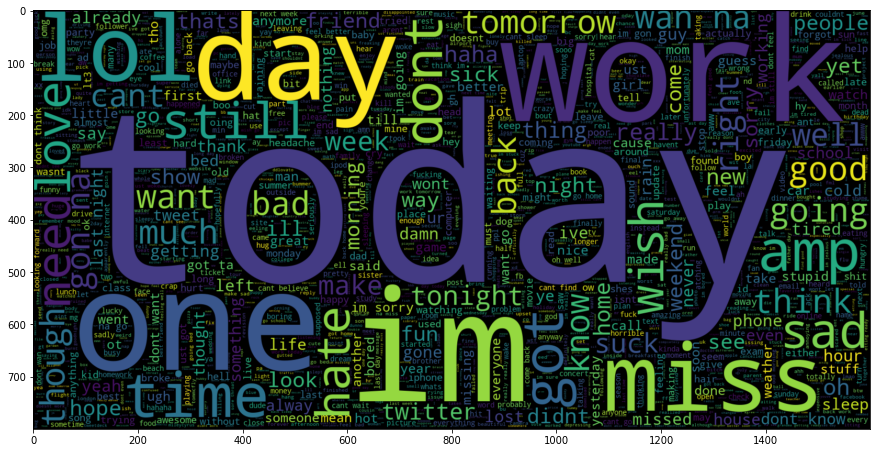

In [ ]:
#ANALYSING THE DATA
#Data polarity = 0

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

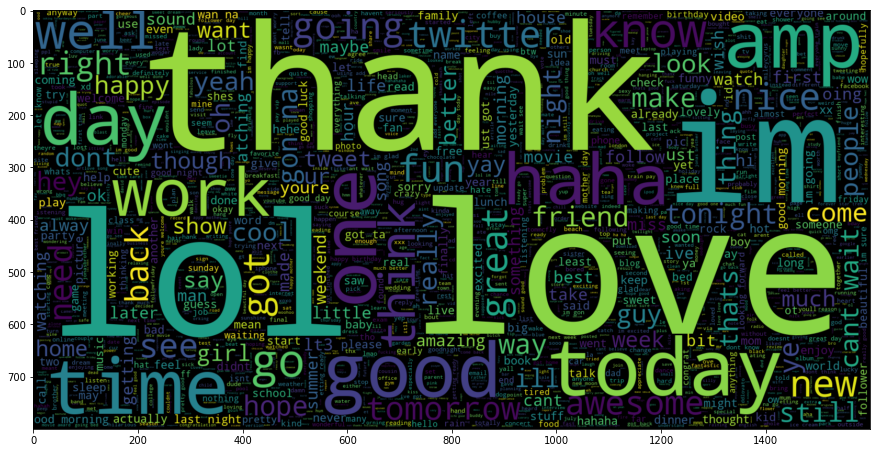

In [ ]:
#ANALYSING THE DATA
#Data polarity = 1 (changed from 4 for better understanding)

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
X = data['processed_tweets'].values
y = data['polarity'].values

In [ ]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)


In [ ]:

#Print the shapes of train and test data

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 169710)
y_train (160000,)

X_test (40000, 169710)
y_test (40000,)


# Model Building

In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# **RNN**
**What is RNN?**

Recurrent neural networks (RNN) are the state of the art algorithm for sequential data and are used by Apple's Siri and and Google's voice search. It is the first algorithm that remembers its input, due to an internal memory, which makes it perfectly suited for machine learning problems that involve sequential data

**Embedding Layer**

Embedding layer is one of the available layers in Keras. This is mainly used in Natural Language Processing related applications such as language modeling, but it can also be used with other tasks that involve neural networks. While dealing with NLP problems, we can use pre-trained word embeddings such as GloVe. Alternatively we can also train our own embeddings using Keras embedding layer.

**LSTM layer**

Long Short Term Memory networks, usually called “LSTMs” , were introduced by Hochreiter and Schmiduber. These have widely been used for speech recognition, language modeling, sentiment analysis and text prediction. Before going deep into LSTM, we should first understand the need of LSTM which can be explained by the drawback of practical use of Recurrent Neural Network (RNN). So, lets start with RNN.

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from time import time
from keras.callbacks import ModelCheckpoint


In [ ]:


max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  108   38    2]
 [   0    0    0 ...   52   13   65]
 [   0    0    0 ... 1173  433  923]
 ...
 [   0    0    0 ... 1813  291   60]
 [   0    0    0 ... 1259 2081 3163]
 [   0    0    0 ...   26    6   33]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.polarity.values, test_size=0.2, random_state=101)

In [ ]:
#Original model With dropout with regularization and use of embedding layer


model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,kernel_regularizer=regularizers.l2(1e-4)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(layers.Dense(8, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(layers.Dense(1,activation='sigmoid'))

#Compile the model with the appropriate loss function
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
start = time()
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)


history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])
print(f'Time taken to run: {time() - start} seconds')

Epoch 1/10
5000/5000 [==============================] - 81s 16ms/step - loss: 0.5514 - accuracy: 0.7210 - val_loss: 0.4994 - val_accuracy: 0.7581

Epoch 00001: val_accuracy improved from -inf to 0.75813, saving model to rnn_model.hdf5
Epoch 2/10
5000/5000 [==============================] - 78s 16ms/step - loss: 0.4754 - accuracy: 0.7738 - val_loss: 0.4868 - val_accuracy: 0.7652

Epoch 00002: val_accuracy improved from 0.75813 to 0.76520, saving model to rnn_model.hdf5
Epoch 3/10
5000/5000 [==============================] - 78s 16ms/step - loss: 0.4552 - accuracy: 0.7857 - val_loss: 0.4882 - val_accuracy: 0.7650

Epoch 00003: val_accuracy did not improve from 0.76520
Epoch 4/10
5000/5000 [==============================] - 78s 16ms/step - loss: 0.4413 - accuracy: 0.7967 - val_loss: 0.4895 - val_accuracy: 0.7664

Epoch 00004: val_accuracy improved from 0.76520 to 0.76640, saving model to rnn_model.hdf5
Epoch 5/10
5000/5000 [==============================] - 78s 16ms/step - loss: 0.4311 - 

In [ ]:
#Accuracy = 0.8358
#Val Accuracy = 0.7498
#Time Taken = 780.82 seconds

In [9]:
#Print the model summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 690,593
Trainable params: 690,593
Non-trainable params: 0
________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


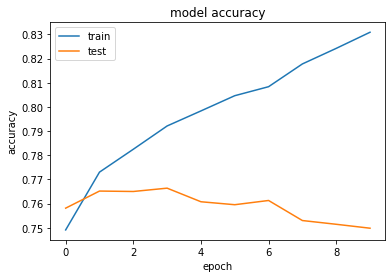

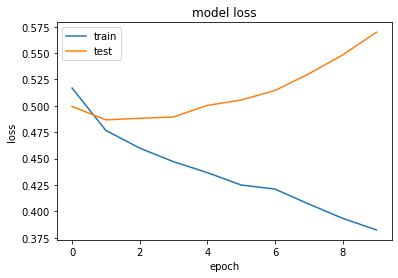

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
predictions_nn_train = model2.predict(X_train)
predictions_nn_test = model2.predict(X_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(y_train, predictions_nn_train))
print('Test accuracy', accuracy_score(y_test, predictions_nn_test))

Train accuracy: 0.851925
Test accuracy 0.749825


In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    

    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_pred1 = []
    for i in y_pred:
      if i[0]>0.5:
        y_pred1.append(1)
      else:
        y_pred1.append(0)
    y_pred = np.asarray(y_pred1)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     19804
           1       0.75      0.75      0.75     20196

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



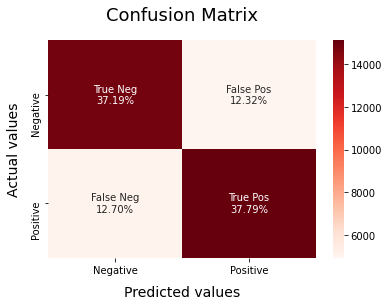

In [ ]:
model_Evaluate(model2)

In [ ]:
#Hyperparameter Tuning
#Dropout: Change the position and value of dropout layer 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from time import time
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,kernel_regularizer=regularizers.l2(1e-4)))
model2.add(layers.Dense(16, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(layers.Dense(8, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(1,activation='sigmoid'))

#Compile the model with the appropriate loss function
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
start = time()
history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])
print(f'Time taken to run: {time() - start} seconds')

Epoch 1/10
5000/5000 [==============================] - 78s 15ms/step - loss: 0.6129 - accuracy: 0.6877 - val_loss: 0.5355 - val_accuracy: 0.7400

Epoch 00001: val_accuracy improved from -inf to 0.74002, saving model to rnn_model2.hdf5
Epoch 2/10
5000/5000 [==============================] - 76s 15ms/step - loss: 0.5336 - accuracy: 0.7466 - val_loss: 0.5050 - val_accuracy: 0.7661

Epoch 00002: val_accuracy improved from 0.74002 to 0.76615, saving model to rnn_model2.hdf5
Epoch 3/10
5000/5000 [==============================] - 76s 15ms/step - loss: 0.5142 - accuracy: 0.7584 - val_loss: 0.5114 - val_accuracy: 0.7557

Epoch 00003: val_accuracy did not improve from 0.76615
Epoch 4/10
5000/5000 [==============================] - 76s 15ms/step - loss: 0.5038 - accuracy: 0.7646 - val_loss: 0.5062 - val_accuracy: 0.7630

Epoch 00004: val_accuracy did not improve from 0.76615
Epoch 5/10
5000/5000 [==============================] - 76s 15ms/step - loss: 0.4916 - accuracy: 0.7736 - val_loss: 0.516

In [ ]:
#Accuracy = 0.8358
#Val Accuracy = 0.7498
#Time Taken = 780.82 seconds

In [10]:
#Print the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 690,593
Trainable params: 690,593
Non-trainable params: 0
________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


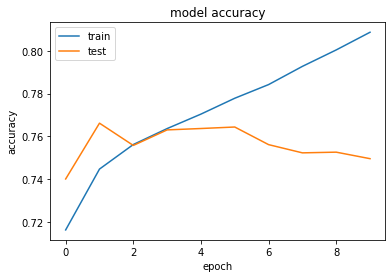

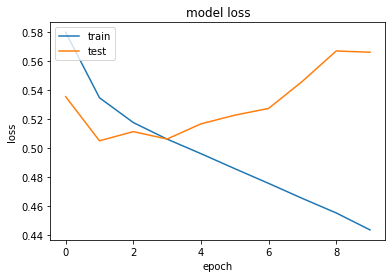

In [ ]:

import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
predictions_nn_train = model2.predict(X_train)
predictions_nn_test = model2.predict(X_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(y_train, predictions_nn_train))
print('Test accuracy', accuracy_score(y_test, predictions_nn_test))

Train accuracy: 0.85294375
Test accuracy 0.749525


In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    

    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_pred1 = []
    for i in y_pred:
      if i[0]>0.5:
        y_pred1.append(1)
      else:
        y_pred1.append(0)
    y_pred = np.asarray(y_pred1)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.73      0.78      0.75     19804
           1       0.77      0.72      0.74     20196

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



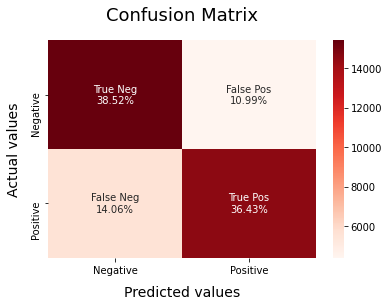

In [ ]:
model_Evaluate(model2)

In [ ]:
#Hyperparameter Tuning
#Regularization: Train a model without regularization 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from time import time
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(16, activation='relu',))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))

#Compile the model with the appropriate loss function
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
start = time()
history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])
print(f'Time taken to run: {time() - start} seconds')

Epoch 1/10
5000/5000 [==============================] - 85s 17ms/step - loss: 0.5399 - accuracy: 0.7197 - val_loss: 0.4801 - val_accuracy: 0.7669

Epoch 00001: val_accuracy improved from -inf to 0.76688, saving model to rnn_model3.hdf5
Epoch 2/10
5000/5000 [==============================] - 85s 17ms/step - loss: 0.4608 - accuracy: 0.7803 - val_loss: 0.4790 - val_accuracy: 0.7680

Epoch 00002: val_accuracy improved from 0.76688 to 0.76800, saving model to rnn_model3.hdf5
Epoch 3/10
5000/5000 [==============================] - 84s 17ms/step - loss: 0.4375 - accuracy: 0.7929 - val_loss: 0.4817 - val_accuracy: 0.7655

Epoch 00003: val_accuracy did not improve from 0.76800
Epoch 4/10
5000/5000 [==============================] - 83s 17ms/step - loss: 0.4196 - accuracy: 0.8030 - val_loss: 0.4907 - val_accuracy: 0.7636

Epoch 00004: val_accuracy did not improve from 0.76800
Epoch 5/10
5000/5000 [==============================] - 78s 16ms/step - loss: 0.3969 - accuracy: 0.8164 - val_loss: 0.509

In [ ]:
#Accuracy = 0.8724
#Val Accuracy = 0.7455
#Time Taken = 827.615 seconds

In [11]:
#Print the model summary
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 690,593
Trainable params: 690,593
Non-trainable params: 0
________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


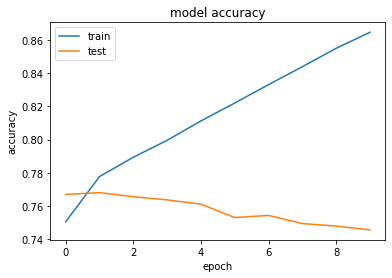

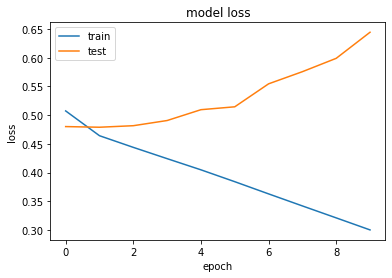

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
predictions_nn_train = model2.predict(X_train)
predictions_nn_test = model2.predict(X_test)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1
print('Train accuracy:', accuracy_score(y_train, predictions_nn_train))
print('Test accuracy', accuracy_score(y_test, predictions_nn_test))

Train accuracy: 0.89219375
Test accuracy 0.745475


In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    

    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    y_pred1 = []
    for i in y_pred:
      if i[0]>0.5:
        y_pred1.append(1)
      else:
        y_pred1.append(0)
    y_pred = np.asarray(y_pred1)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     19804
           1       0.74      0.76      0.75     20196

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



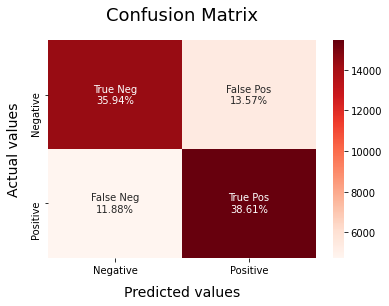

In [ ]:
model_Evaluate(model2)

In [ ]:
#Model3 without regularisation is performing the best among the 3 models 
#There was no overfiting so we dont need to use regularisation here